In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import io, filters, img_as_float
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Apply Sobel Filter 
Applying sobel filter using skimage to make dataset


In [4]:
input_dir = '/kaggle/input/wth-dataset/natural_images'  # Replace with your dataset directory
output_dir = '/kaggle/input/wth-dataset/sobel_filtered_dataset'  # Directory to save processed images
folders = next(os.walk(input_dir))[1]

In [5]:
folders

['motorbike', 'airplane', 'flower', 'dog', 'fruit', 'car', 'cat', 'person']

In [ ]:
# Create directories if they don't exist
os.makedirs(output_dir, exist_ok=True)
original_dir = os.path.join(output_dir, 'original')
sobel_dir = os.path.join(output_dir, 'sobel')
os.makedirs(original_dir, exist_ok=True)
os.makedirs(sobel_dir, exist_ok=True)

In [ ]:
# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

In [ ]:

# Function to process images in a directory
def process_images_in_dir(input_folder, output_folder):
    
    # Create the corresponding output folder
    os.makedirs(output_folder, exist_ok=True)
    
    # Iterate over each image file in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
            
            # Load the image
            img_path = os.path.join(input_folder, filename)
            image = io.imread(img_path)

            # Convert to grayscale if it's a color image
            gray_image = rgb2gray(image) if len(image.shape) == 3 else image

            # Apply the Sobel filter
            sobel_image = filters.sobel(gray_image)

            # Convert images to uint8 format for saving
            sobel_image_uint8 = img_as_ubyte(sobel_image)

            # Save Sobel-filtered images
            sobel_save_path = os.path.join(output_folder, filename)
            io.imsave(sobel_save_path, sobel_image_uint8)
            
            print(f'Processed and saved {filename} in {output_folder}')

# Traverse the input directory structure
for root, dirs, files in os.walk(input_dir):
    for dir_name in dirs:
        input_subdir = os.path.join(root, dir_name)
        output_subdir = os.path.join(output_dir, dir_name)
        process_images_in_dir(input_subdir, output_subdir)

print("Dataset preparation complete!")


# Training Neural Network

In [8]:
IMG_CHANNELS = 1  # For grayscale images
STANDARD_HEIGHT = 256 
STANDARD_WIDTH = 256  

In [9]:
#Load the saved original and sobel images
original_images = []
sobel_images = []   

for folder in folders:
    original_dir = os.path.join("/kaggle/input/wth-dataset/natural_images", folder)
    sobel_dir = os.path.join("/kaggle/input/wth-dataset/sobel_filtered_dataset", folder)

    for filename in os.listdir(original_dir):
        original_path = os.path.join(original_dir, filename)
        sobel_path = os.path.join(sobel_dir, filename)
        
        # Load images
        original_image = img_as_float(io.imread(original_path, as_gray=True))
        sobel_image = img_as_float(io.imread(sobel_path, as_gray=True))
        
        #Expand dimensions for resizing
        original_image_expanded = tf.expand_dims(original_image, axis=-1)
        sobel_image_expanded = tf.expand_dims(sobel_image, axis=-1)
        
        # Resize or pad images to a standard size
        original_image_resized = tf.image.resize_with_pad(original_image_expanded, STANDARD_HEIGHT, STANDARD_WIDTH)
        sobel_image_resized = tf.image.resize_with_pad(sobel_image_expanded, STANDARD_HEIGHT, STANDARD_WIDTH)
       
        original_images.append(original_image_resized)
        sobel_images.append(sobel_image_resized)

In [10]:
#Make numpy array of the images
X=np.array(original_images)
y=np.array(sobel_images)

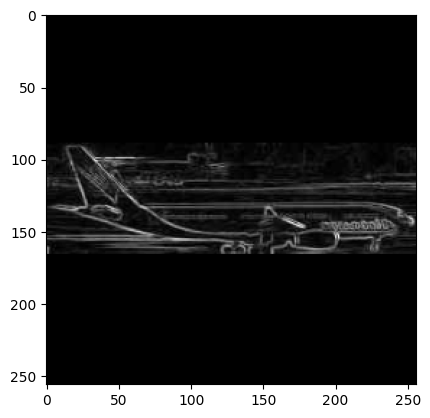

In [9]:
#checking an image in y
plt.imshow(y[1000].squeeze(), cmap='gray')

In [10]:
X.shape

(6899, 256, 256, 1)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(STANDARD_HEIGHT, STANDARD_WIDTH, IMG_CHANNELS)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding='valid'),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding='valid'),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2), padding='valid'),
    layers.Dropout(0.3),

    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.UpSampling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.UpSampling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.UpSampling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])



In [13]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])

In [14]:
model.fit(X_train, y_train, batch_size=8, epochs=30, validation_split=0.25)


Epoch 1/30


I0000 00:00:1725263144.094784      98 service.cc:145] XLA service 0x7887c80057d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725263144.094882      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/518 ━━━━━━━━━━━━━━━━━━━━ 3:38:13 25s/step - loss: 0.4814 - mean_absolute_error: 0.4814

I0000 00:00:1725263164.016097      98 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1725263164.036646      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


518/518 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.1017 - mean_absolute_error: 0.1017

I0000 00:00:1725263222.221074     100 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads



518/518 ━━━━━━━━━━━━━━━━━━━━ 93s 131ms/step - loss: 0.1016 - mean_absolute_error: 0.1016 - val_loss: 0.0372 - val_mean_absolute_error: 0.0372
Epoch 2/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - loss: 0.0252 - mean_absolute_error: 0.0252 - val_loss: 0.0346 - val_mean_absolute_error: 0.0346
Epoch 3/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - loss: 0.0221 - mean_absolute_error: 0.0221 - val_loss: 0.0284 - val_mean_absolute_error: 0.0284
Epoch 4/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - loss: 0.0204 - mean_absolute_error: 0.0204 - val_loss: 0.0246 - val_mean_absolute_error: 0.0246
Epoch 5/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - loss: 0.0192 - mean_absolute_error: 0.0192 - val_loss: 0.0297 - val_mean_absolute_error: 0.0297
Epoch 6/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - loss: 0.0184 - mean_absolute_error: 0.0184 - val_loss: 0.0201 - val_mean_absolute_error: 0.0201
Epoch 7/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - loss: 0.0177 - mean_absolute_error: 0.0177

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



518/518 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - loss: 0.0136 - mean_absolute_error: 0.0136 - val_loss: 0.0228 - val_mean_absolute_error: 0.0228
Epoch 22/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - loss: 0.0135 - mean_absolute_error: 0.0135 - val_loss: 0.0173 - val_mean_absolute_error: 0.0173
Epoch 23/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - loss: 0.0136 - mean_absolute_error: 0.0136 - val_loss: 0.0234 - val_mean_absolute_error: 0.0234
Epoch 24/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - loss: 0.0136 - mean_absolute_error: 0.0136 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237
Epoch 25/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - loss: 0.0133 - mean_absolute_error: 0.0133 - val_loss: 0.0258 - val_mean_absolute_error: 0.0258
Epoch 26/30
518/518 ━━━━━━━━━━━━━━━━━━━━ 82s 93ms/step - loss: 0.0131 - mean_absolute_error: 0.0131 - val_loss: 0.0246 - val_mean_absolute_error: 0.0246
Epoch 27/30
221/518 ━━━━━━━━━━━━━━━━━━━━ 25s 85ms/step - loss: 0.0134 - mean_absolute_error: 0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')

44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - loss: 0.0129 - mean_absolute_error: 0.0129
Test Loss: 0.012959538027644157
Test MAE: 0.012959539890289307


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step


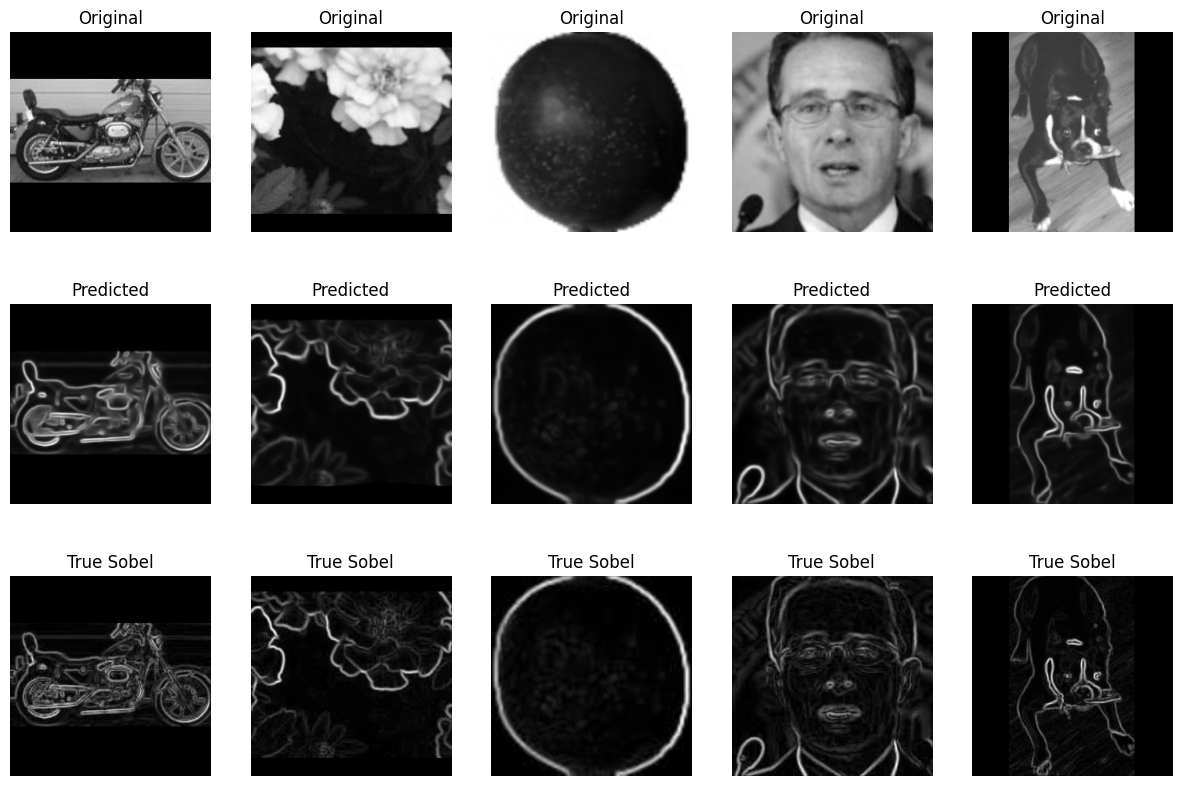

In [17]:
predictions = model.predict(X_test)

# Define a function to display images
def display_images(original, predicted, index, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.imshow(original[index + i].squeeze(), cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(predicted[index + i].squeeze(), cmap='gray')
        plt.title('Predicted')
        plt.axis('off')
        
        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(y_test[index + i].squeeze(), cmap='gray')
        plt.title('True Sobel')
        plt.axis('off')
    plt.show()

# Display some images
display_images(X_test, predictions2, index=0, num_images=5)

In [18]:
# Save the model
model.save('sobel_filter_model_weights.h5')


Training complete and model saved!
